# Aprendizado não-supervisionado: outlier detection

### Bibliotecas básicas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy.optimize import linprog

### Bibliotecas de Machine Learning

In [2]:
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Analisando o impacto de outliers no modelo

#### Gerando dados

In [3]:
np.random.seed(1)
n= 40

x= np.linspace(0, 2, 40).reshape(-1, 1)
fx= .5 * x + 3
ruido= np.random.normal(scale=0.1, size=(n, 1))
y= fx + ruido

#### Modelo linear

In [4]:
linear_regression= LinearRegression()
linear_regression.fit(x, y)

y_pred= linear_regression.predict(x)
mse1= mean_squared_error(y, y_pred)

#### Plot da predição

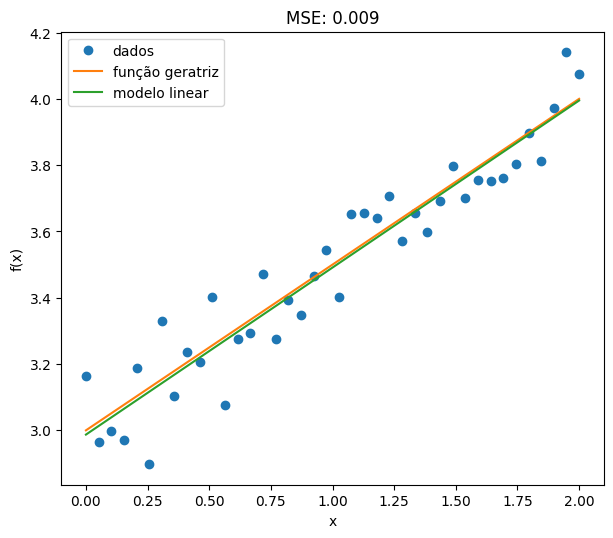

In [5]:
plt.figure(figsize=[7, 6], dpi=100)
plt.plot(x, y, 'o', label='dados')
plt.plot(x, fx, label='função geratriz')
plt.plot(x, y_pred, label='modelo linear')

plt.title('MSE: {:.3f}'.format(mse1))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

### Adição de outlier

#### Adiciona o ruído no dado

In [6]:
y_outlier= y.copy()
y_outlier[2:5] += 0.7

#### Modelo linear

In [7]:
linear_regressor = LinearRegression()
linear_regressor.fit(x, y_outlier)
y_pred = linear_regressor.predict(x)
mse2 = mean_squared_error(y, y_pred)

#### Plot da predição

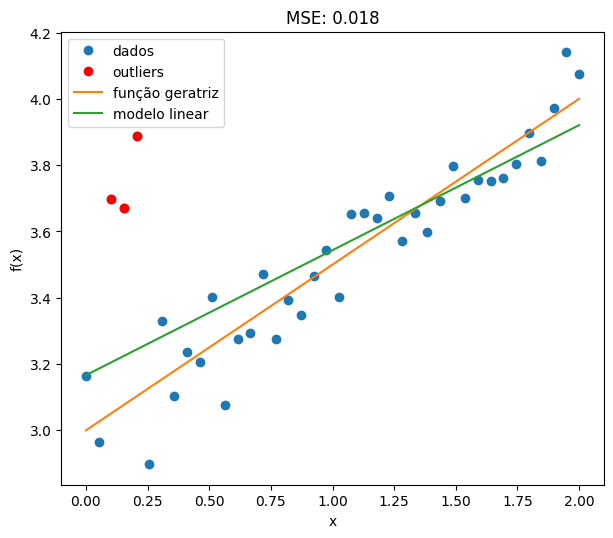

In [8]:
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x, y_outlier, 'o', label='dados')
plt.plot(x[2:5], y_outlier[2:5], 'ro', label='outliers')
plt.plot(x, fx, label='função geratriz')
plt.plot(x, y_pred, label='modelo linear')

plt.title('MSE: {:.3f}'.format(mse2))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

### Função de erro robusta

#### Regressão Norma-1

In [9]:
class NormOneRegression():
    
    def __init__(self, fit_intercept=True):
        
        self.fit_intercept= fit_intercept
        self.beta= None
        
    def fit(self, x, y):
        
        if self.fit_intercept:
            X= np.c_[np.ones(x.shape), x]
        else:
            X= x.copy()
        
        n, m= X.shape
        
        A_ub1= np.c_[X, -np.eye(n)]
        A_ub2= np.c_[-X, -np.eye(n)]
        A_ub= np.r_[A_ub1, A_ub2]
        
        b_ub= np.r_[y, -y]
        
        c= np.ones((A_ub.shape[1], 1))
        c[0:m]= 0
        
        x_bounds = np.c_[-np.inf * np.ones((m+n, 1)), np.inf * np.ones((m+n, 1))]
        x_bounds[m:, 0] = 0


        output = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, options={'cholesky':False, 'sym_pos':False, 'lstsq':True, 
                                                                            'presolve':True})


        self.beta = output.x[:m].reshape(-1, 1)

     
    def predict(self, X):

        if self.fit_intercept:
            X = np.c_[np.ones(x.shape), x]
        else:
            X = x.copy()

        return np.dot(X, self.beta)

#### Modelo otimizando a norma-1

In [10]:
model = NormOneRegression()
model.fit(x, y_outlier)

y_pred = model.predict(x)
mse4 = mean_squared_error(y, y_pred)

#### Plot da predição

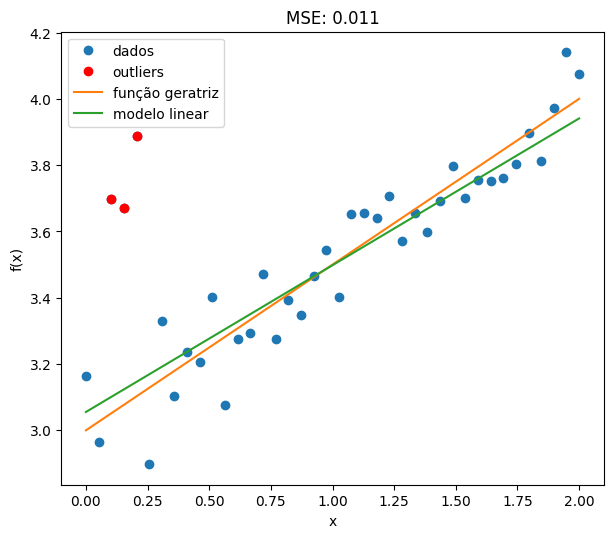

In [11]:
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x, y_outlier, 'o', label='dados')
plt.plot(x[2:5], y_outlier[2:5], 'ro', label='outliers')
plt.plot(x, fx, label='função geratriz')
plt.plot(x, y_pred, label='modelo linear')

plt.title('MSE: {:.3f}'.format(mse4))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [12]:
print('Melhoria percentual do MSE utilizando a nova função de custo {:.2f} (%)'.format((mse2-mse4)/mse2*100))

Melhoria percentual do MSE utilizando a nova função de custo 39.73 (%)


### Outlier detection: Isolation Forest

#### Parâmetros dos dados

In [13]:
n_samples = 200
outliers_fraction = 0.25
x_min, x_max = -7, 7

#### Real

In [14]:
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

#### Amostras inliers

In [15]:
np.random.seed(1)

offset = 0
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
X = np.r_[X1, X2]

#### Amostras outliers

In [16]:
X = np.r_[X, np.random.uniform(low=x_min+1, high=x_max-1, size=(n_outliers, 2))]

#### Visualização inicial dos dados

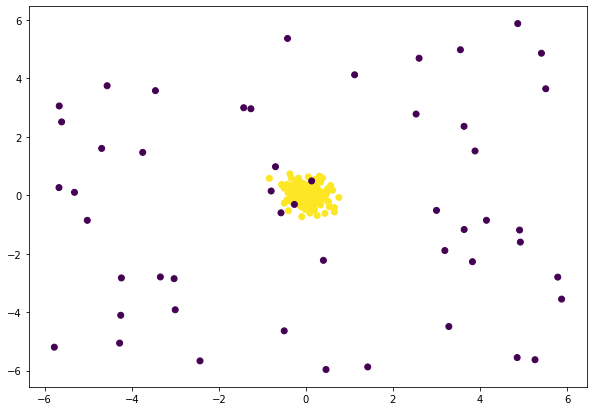

In [17]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=ground_truth)
plt.show()

#### Outliear detector model

In [18]:
outlier_detector = IsolationForest()

#### Função de plot

In [19]:
def plot_decision_function(model, X):
  """ Plot da superfície de decisão do modelo.

    Args:
      model: instancia do modelo.
      X: matriz com os dados.
  """
 
  # fit do modelo e determinação de outliers
  outlier_detector.fit(X)
  scores_pred = outlier_detector.decision_function(X) 
  y_pred = outlier_detector.predict(X)
  threshold = np.percentile(scores_pred[::-1], 100 * outliers_fraction)
  n_errors = (y_pred != ground_truth).sum() 

  # meshgrid
  n_points_grid = 100
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points_grid),
                       np.linspace(x_min, x_max, n_points_grid))
  Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
  Z = Z.reshape(xx.shape)

  # plot das curvas de nível e dos pontos
  plt.figure(figsize=(7, 6), dpi=100)
  subplot = plt.subplot(1, 1, 1)
  cs = subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                        cmap=plt.cm.Blues_r)
  a = subplot.contour(xx, yy, Z, levels=[threshold],
                      linewidths=2, colors='red')
  subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                    colors='orange')
  b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                      s=20, edgecolor='k')
  c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                      s=20, edgecolor='k')
  subplot.axis('tight')
  subplot.legend(
      [a.collections[0], b, c],
      ['superfíce de decisão aprendida',
       'verdadeiros inliers',
       'verdadeiros outliers'],
      prop=matplotlib.font_manager.FontProperties(size=10),
      loc='lower right')
  subplot.set_xlim((-7, 7))
  subplot.set_ylim((-7, 7))
  plt.colorbar(cs)
  plt.title('Outlier detection,' +
            f' # de erros: {n_errors} ({n_errors/n_samples*100}%)')
  plt.show() 

#### Visualização dos resultados

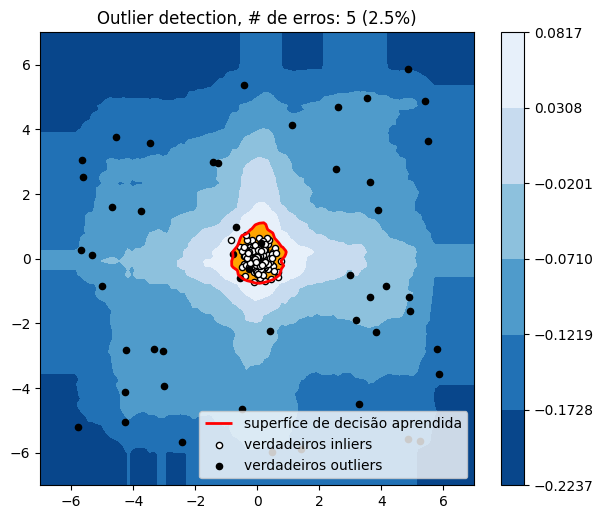

In [20]:
plot_decision_function(model=outlier_detector, X=X)